In [398]:
# Dependencies 
import pandas as pd
import os
from datetime import datetime
from bs4 import BeautifulSoup
import glob as glob
import plotly.express as px
import numpy as np

In [399]:
# Import alternate championhsip points tables
points_table_formula1 = pd.read_csv('points_systems_csv/2024_formula1_race_points_table.csv')
points_table_imsa = pd.read_csv('points_systems_csv/2024_imsa_race_points_table.csv')
points_table_imsa_qual = pd.read_csv('points_systems_csv/2024_imsa_qualifying_points_table.csv')

# Get the full-season table from HTML
season_html = soup.find(id = 'race-alltime')
season_data = []
# Loop through table html and parse to list
for row in season_html.find_all('tr'):
    row_data = [cell.get_text(strip=True) for cell in row.find_all(['th', 'td'])]
    season_data.append(row_data)
season_df = pd.DataFrame(season_data[1:], columns=season_data[0])
season_df["Date"] = pd.to_datetime(season_df["Date"])
season_df = season_df.drop([1, 2])
season_df = season_df.drop("Avg.Speed", axis=1).drop("Winner", axis=1).drop("Car/Engine", axis=1).drop("Start Position", axis=1)
season_df.reset_index(drop=True, inplace=True)
season_df.index += 1
season_df

Date                                    Track     Track Type
1  2024-03-10                Streets of St. Petersburg  Street Course
2  2024-03-24                         The Thermal Club    Road Course
3  2024-04-21                    Streets of Long Beach  Street Course
4  2024-04-28                  Barber Motorsports Park    Road Course
5  2024-05-11  Indianapolis Motor Speedway Road Course    Road Course
6  2024-05-26              Indianapolis Motor Speedway           Oval
7  2024-06-02                       Streets of Detroit  Street Course
8  2024-06-09                             Road America    Road Course
9  2024-06-23          WeatherTech Raceway Laguna Seca    Road Course
10 2024-07-07               Mid-Ohio Sports Car Course    Road Course
11 2024-07-14                            Iowa Speedway           Oval
12 2024-07-14                            Iowa Speedway           Oval
13 2024-07-21                       Streets of Toronto  Street Course
14 2024-08-17            World Wide Technology Raceway           Oval
15 2024-08-25           Portland International Raceway    Road Course

In [400]:
all_files_path = 'race_results_html/*.htm'
race_results_files = []
race_results_files = glob.glob(all_files_path)

season_races_df = pd.DataFrame()

# Initialize a list to contain the race results 
race_result_data = []
i = 0

for race_result_file in race_results_files:
# Get City / Race Name
    i += 1
    j = 0
    city = race_result_file.split('.')[0]
    city = city[18:]
# Read html file and store as html_content
    with open(race_result_file, 'r') as file:
        html_content = file.read()
    # Parse race result table html
    soup = BeautifulSoup(html_content, 'html.parser')
    race_table_html = soup.find(id = 'race-season')

# Loop through table html and parse to list
    for row in race_table_html.find_all('tr'):
        j += 1
        row_data = [cell.get_text(strip=True) for cell in row.find_all(['th', 'td'])]
        if j == 1 and i == 1:
            row_data_with_city = row_data + ['City']
            race_result_data.append(row_data_with_city)
        elif j != 1:
            row_data_with_city = row_data + [city]
            race_result_data.append(row_data_with_city)
        else:
            pass

    race_result_df = pd.DataFrame(race_result_data[1:], columns=race_result_data[0])
    race_result_df['Rank'] = race_result_df['Rank'].astype('int')
    race_result_df['Starts'] = race_result_df['Starts'].astype('int')
    race_result_df['Laps'] = race_result_df['Laps'].astype('int')
    race_result_df['Laps Led'] = race_result_df['Laps Led'].replace('-', 0).astype('int')
    race_result_df['Points'] = race_result_df['Points'].astype('int')
    race_result_df['Pit stop'] = race_result_df['Pit stop'].astype('int64')

    race_result_df = pd.merge(race_result_df, points_table_formula1, on='Rank', how='inner')
    race_result_df = pd.merge(race_result_df, points_table_imsa, on='Rank', how='inner')
    race_result_df = pd.merge(race_result_df, points_table_imsa_qual, on='Starts', how='inner')
    race_result_df['Points (IMSA Scoring)'] = race_result_df['Points (IMSA Scoring)']+race_result_df['Points (IMSA Scoring) - Qualifying']
    race_result_df = race_result_df.drop(columns=['Points (IMSA Scoring) - Qualifying'])

    

race_result_df.sample(46)

Rank               Driver Car No.  Starts  Laps     Total time  Laps Led  \
94     14         Nolan Siegel       6      11   250  01:27:06.8768         0   
342    12         Rinus VeeKay      21      10   205  01:43:32.1299         0   
156    22      Romain Grosjean      77       5    82  01:33:29.4950         0   
315    12     Santino Ferrucci      14      17   258  02:22:35.5855         0   
420     9     Marcus Armstrong      11       6    90  01:56:53.8148         0   
129    22  Christian Lundgaard      45      23   178  01:41:39.5544         0   
430    19        Tom Blomqvist      66      12    90  01:57:00.3524         0   
337     7     Marcus Armstrong      11      12   206  01:43:29.6404         0   
408    24       Hunter McElrea      18      25    57  01:04:49.1748         0   
130    23           Alex Palou      10       3   175  01:07:09.0616         0   
214    25      Josef Newgarden       2      17    79  01:33:41.0299         0   
114     7        Kyle Kirkwood      27      19   250  01:44:49.5372         0   
47     21     Santino Ferrucci      14      24    84  01:42:12.4251         0   
285     9  Christian Lundgaard      45      26   250  02:03:22.9163         0   
367    10           Will Power      12       4   250  02:06:51.2558        64   
317    14    Pietro Fittipaldi      30      15   258  02:22:43.0743         0   
28      2         Colton Herta      26       4    85  01:42:04.1214         7   
75     22         Luca Ghiotto      51      23    55  01:46:40.1879         0   
296    20         Graham Rahal      15      21   248  02:03:29.2672         0   
387     3          Scott Dixon       9      15    85  01:39:29.3973         3   
410    26     Agustin Canapino      78      10     4  00:06:13.8674         0   
192     3     Scott McLaughlin       3       6    80  01:33:38.7749         3   
74     21          Scott Dixon       9      10    55  01:46:24.5021         0   
286    10          Scott Dixon       9      17   250  02:03:23.2204         0   
461    23       Kyffin Simpson       4      22    86  01:50:32.2312         0   
243    27     Felix Rosenqvist      60       9    55  00:51:59.8657         0   
391     7  Christian Lundgaard      45      16    85  01:39:32.3218         0   
39     13      Linus Lundqvist       8      17    85  01:42:45.1419         0   
454    16        David Malukas      66      12    95  02:04:28.3554         0   
447     9     Santino Ferrucci      14      17    95  02:04:20.8570         0   
251     2           Will Power      12       3    85  01:45:33.8426         0   
168     7     Scott McLaughlin       3      20   110  01:56:16.5446         0   
11     12     Agustin Canapino      78      17   100  02:06:35.3358         0   
176    15          Pato O'Ward       5      22   110  01:56:32.5878         0   
233    17         Ed Carpenter      20      17   200  02:58:58.3160         3   
305     2     Scott McLaughlin       3       1   260  02:22:30.0032        67   
394    10         Graham Rahal      15       8    85  01:39:34.5749         0   
69     16    Pietro Fittipaldi      30      25    55  01:46:04.7428         0   
15     16           Alex Palou      10       2   100  02:06:47.0122         1   
72     19    Helio Castroneves      66      27    55  01:46:15.7185         0   
268    19      Theo Pourchaire       6      18    85  01:46:05.2999         0   
429    18      Marcus Ericsson      28      18    90  01:56:59.6210         0   
371    14          Jack Harvey      18      13   247  02:06:48.2333         0   
87      7      Josef Newgarden       2      14   250  01:26:43.6064         0   
121    14       Kyffin Simpson       4      27   250  01:44:54.6220         0   
112     5         Rinus VeeKay      21      13   250  01:44:47.6828         0   

         Status  Points Avg.Speed  Pit stop          City  \
94      Running      16   153.935         2         iowa2   
342     Running      18   158.004         4     nashville   
156  Mechanica

In [401]:
# Get a list of cities from race_result_df and convert it to a data frame
race_numbers = race_result_df.groupby('City')['City'].count()
race_numbers_df = pd.DataFrame(race_numbers)

# Define each race's race number
race_numbers_df.at['stpetersburg', 'Race Number'] = 1
race_numbers_df.at['longbeach', 'Race Number'] = 2
race_numbers_df.at['barber', 'Race Number'] = 3
race_numbers_df.at['indyrc', 'Race Number'] = 4
race_numbers_df.at['indy500', 'Race Number'] = 5
race_numbers_df.at['detroit', 'Race Number'] = 6
race_numbers_df.at['roadamerica', 'Race Number'] = 7
race_numbers_df.at['lagunaseca', 'Race Number'] = 8
race_numbers_df.at['midohio', 'Race Number'] = 9
race_numbers_df.at['iowa1', 'Race Number'] = 10
race_numbers_df.at['iowa2', 'Race Number'] = 11
race_numbers_df.at['toronto', 'Race Number'] = 12
race_numbers_df.at['gateway', 'Race Number'] = 13
race_numbers_df.at['portland', 'Race Number'] = 14
race_numbers_df.at['milwaukee1', 'Race Number'] = 15
race_numbers_df.at['milwaukee2', 'Race Number'] = 16
race_numbers_df.at['nashville', 'Race Number'] = 17

race_numbers_df.at['stpetersburg', 'Track Type'] = 'Street Course'
race_numbers_df.at['longbeach', 'Track Type'] = 'Street Course'
race_numbers_df.at['barber', 'Track Type'] = 'Road Course'
race_numbers_df.at['indyrc', 'Track Type'] = 'Road Course'
race_numbers_df.at['indy500', 'Track Type'] = 'Oval'
race_numbers_df.at['detroit', 'Track Type'] = 'Street Course'
race_numbers_df.at['roadamerica', 'Track Type'] = 'Road Course'
race_numbers_df.at['lagunaseca', 'Track Type'] = 'Road Course'
race_numbers_df.at['midohio', 'Track Type'] = 'Road Course'
race_numbers_df.at['iowa1', 'Track Type'] = 'Oval'
race_numbers_df.at['iowa2', 'Track Type'] = 'Oval'
race_numbers_df.at['toronto', 'Track Type'] = 'Street Course'
race_numbers_df.at['gateway', 'Track Type'] = 'Oval'
race_numbers_df.at['portland', 'Track Type'] = 'Road Course'
race_numbers_df.at['milwaukee1', 'Track Type'] = 'Oval'
race_numbers_df.at['milwaukee2', 'Track Type'] = 'Oval'
race_numbers_df.at['nashville', 'Track Type'] = 'Oval'

#Clean the data frame
race_numbers_df['Race Number'] = race_numbers_df['Race Number'].astype('int64')
race_numbers_df = race_numbers_df.sort_values(by='Race Number')
race_numbers_df.rename(columns={'City': 'City2'}, inplace=True)
race_numbers_df.drop(columns=['City2'], inplace=True)
race_numbers_df = race_numbers_df.reset_index()

# Merge the data frames, thereby giving the race_result_df dataframe a race number, and sort by the race number and rank 
race_result_df = pd.merge(race_result_df, race_numbers_df, on='City', how='inner')
race_result_df_sorted = race_result_df.sort_values(by=['Race Number', 'Rank'])
race_result_df_sorted

Rank            Driver Car No.  Starts  Laps     Total time  Laps Led  \
135     1       Pato O'Ward       5       3   100  01:51:37.5075         0   
136     2        Will Power      12       8   100  01:51:38.6513         0   
137     3      Colton Herta      26       4   100  01:51:39.8532         1   
138     4        Alex Palou      10      13   100  01:51:41.3990         0   
139     5  Felix Rosenqvist      60       2   100  01:51:43.9998         0   
..    ...               ...     ...     ...   ...            ...       ...   
353    23      Graham Rahal      15      19   202  01:43:32.0545         0   
354    24        Will Power      12       4   198  01:43:24.6827         0   
355    25   Marcus Ericsson      28      15   137  01:19:42.9340         0   
356    26   Katherine Legge      51      22    85  00:43:09.5186         0   
357    27  Felix Rosenqvist      60       3    55  00:23:12.4834         0   

      Status  Points Avg.Speed  Pit stop          City  Points (F1 Scoring)  \
135  Running      50    96.752         2  stpetersburg                   25   
136  Running      30    96.736         2  stpetersburg                   18   
137  Running      36    96.719         2  stpetersburg                   15   
138  Running      32    96.696         2  stpetersburg                   12   
139  Running      30    96.659         2  stpetersburg                   10   
..       ...     ...       ...       ...           ...                  ...   
353  Running       7   155.693         4     nashville                    0   
354  Running       6   152.792         6     nashville                    0   
355  Contact       5   137.145         3     nashville                    0   
356  Contact       5   157.164         2     nashville                    0   
357  Contact       5   189.115         0     nashville                    0   

     Points (IMSA Scoring)  Race Number     Track Type  
135                    380            1  Street Course  
136                    343            1  Street Course  
137                    328            1  Street Course  
138                    298            1  Street Course  
139                    292            1  Street Course  
..                     ...          ...            ...  
353                     92           17           Oval  
354                     98           17           Oval  
355                     76           17           Oval  
356                     59           17           Oval  
357                     70           17           Oval  

[466 rows x 16 columns]

In [402]:
race_result_df_sorted = race_result_df_sorted.replace('stpetersburg', 'St. Petersburg').replace('longbeach', 'Long Beach').replace('barber', 'Barber').replace('indyrc', 'Indy Road Course').replace('indy500', 'Indy 500').replace('detroit', 'Detroit').replace('roadamerica', 'Road America').replace('lagunaseca', 'Laguna Seca').replace('midohio', 'Mid-Ohio').replace('iowa1', 'Iowa 1').replace('iowa2', 'Iowa 2').replace('toronto', 'Toronto').replace('gateway', 'Gateway').replace('portland', 'Portland').replace('milwaukee1', 'Milwaukee 1').replace('milwaukee2', 'Milwaukee 2').replace('nashville', 'Nashville')
race_result_df_sorted.rename(columns={'City': 'Race'}, inplace=True)
race_result_df_sorted

Rank            Driver Car No.  Starts  Laps     Total time  Laps Led  \
135     1       Pato O'Ward       5       3   100  01:51:37.5075         0   
136     2        Will Power      12       8   100  01:51:38.6513         0   
137     3      Colton Herta      26       4   100  01:51:39.8532         1   
138     4        Alex Palou      10      13   100  01:51:41.3990         0   
139     5  Felix Rosenqvist      60       2   100  01:51:43.9998         0   
..    ...               ...     ...     ...   ...            ...       ...   
353    23      Graham Rahal      15      19   202  01:43:32.0545         0   
354    24        Will Power      12       4   198  01:43:24.6827         0   
355    25   Marcus Ericsson      28      15   137  01:19:42.9340         0   
356    26   Katherine Legge      51      22    85  00:43:09.5186         0   
357    27  Felix Rosenqvist      60       3    55  00:23:12.4834         0   

      Status  Points Avg.Speed  Pit stop            Race  Points (F1 Scoring)  \
135  Running      50    96.752         2  St. Petersburg                   25   
136  Running      30    96.736         2  St. Petersburg                   18   
137  Running      36    96.719         2  St. Petersburg                   15   
138  Running      32    96.696         2  St. Petersburg                   12   
139  Running      30    96.659         2  St. Petersburg                   10   
..       ...     ...       ...       ...             ...                  ...   
353  Running       7   155.693         4       Nashville                    0   
354  Running       6   152.792         6       Nashville                    0   
355  Contact       5   137.145         3       Nashville                    0   
356  Contact       5   157.164         2       Nashville                    0   
357  Contact       5   189.115         0       Nashville                    0   

     Points (IMSA Scoring)  Race Number     Track Type  
135                    380            1  Street Course  
136                    343            1  Street Course  
137                    328            1  Street Course  
138                    298            1  Street Course  
139                    292            1  Street Course  
..                     ...          ...            ...  
353                     92           17           Oval  
354                     98           17           Oval  
355                     76           17           Oval  
356                     59           17           Oval  
357                     70           17           Oval  

[466 rows x 16 columns]

In [403]:
driver_car_colors = {'Agustin Canapino': '#01FF4F',
 'Alex Palou': '#FFCC00',
 'Alexander Rossi': '#FF7200',
 'Callum Ilott': '#FF7200',
 'Christian Lundgaard': '#D62017',
 'Christian Rasmussen': '#0095DA',
 'Colin Braun': '#C72017',
 'Colton Herta': '#EFC21C',
 'Conor Daly': '#01FF4F',
 'David Malukas': '#D21281',
 'Ed Carpenter': '#0095DA',
 'Felix Rosenqvist': '#D21281',
 'Graham Rahal': '#2B4787',
 'Helio Castroneves': '#0361A1',
 'Hunter McElrea': '#8BAC2E',
 'Jack Harvey': '#8BAC2E',
 'Josef Newgarden': '#016690',
 'Juri Vips': '#D12230',
 'Katherine Legge': '#F085B1',
 'Kyffin Simpson': '#0C4C91',
 'Kyle Kirkwood': '#D21281',
 'Kyle Larson': '#FF7200',
 'Linus Lundqvist': '#173D6D',
 'Luca Ghiotto': '#C72017',
 'Marco Andretti': '#09629C',
 'Marcus Armstrong': '#00904B',
 'Marcus Ericsson': '#379985',
 'Nolan Siegel': '#FF7200',
 "Pato O'Ward": '#FF7200',
 'Pietro Fittipaldi': '#E5D21E',
 'Rinus VeeKay': '#5DB446',
 'Romain Grosjean': '#01FF4F',
 'Ryan Hunter-Reay': '#C75A2E',
 'Santino Ferrucci': '#313232',
 'Scott Dixon': '#D1602A',
 'Scott McLaughlin': '#FBD302',
 'Sting Ray Robb': '#FCEE04',
 'Takuma Sato': '#D12230',
 'Theo Pourchaire': '#FF7200',
 'Toby Sowery': '#C72017',
 'Tom Blomqvist': '#D21281',
 'Tristan Vautier': '#C72017',
 'Will Power': '#EC2026'}

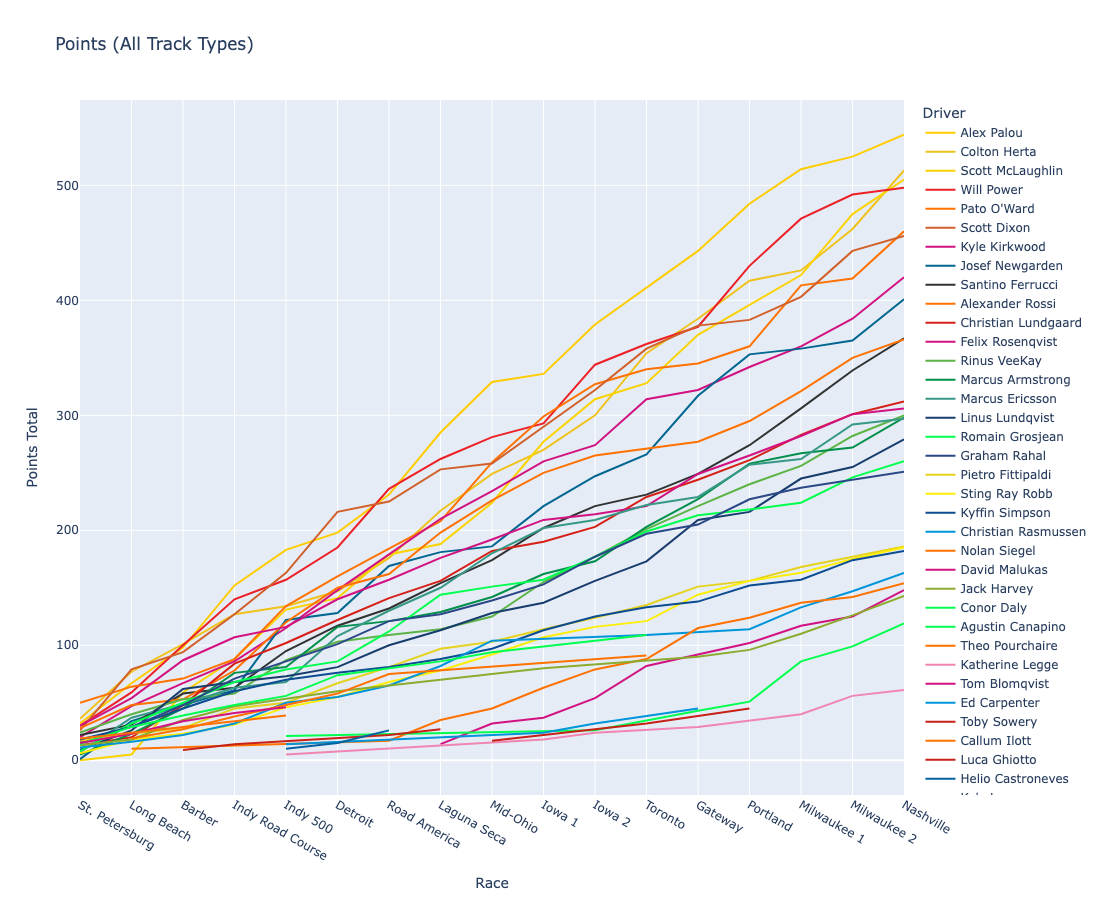

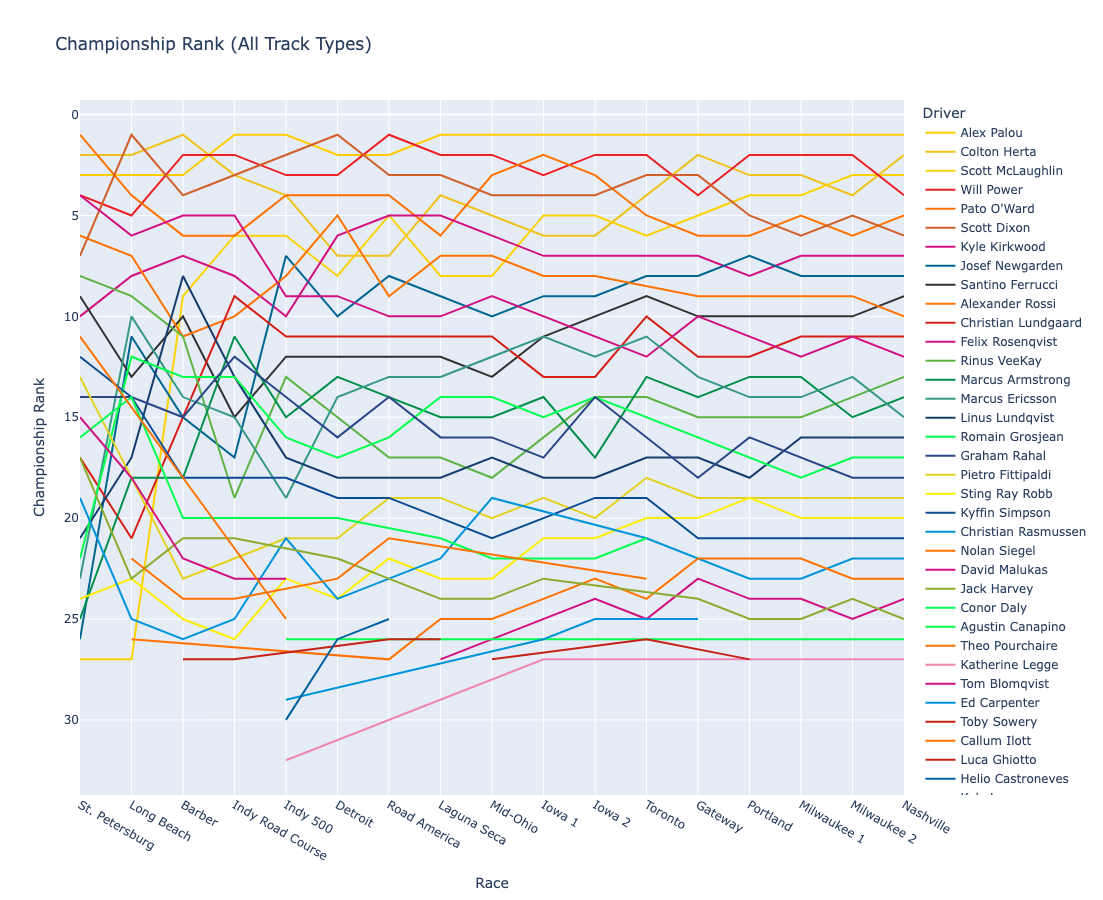

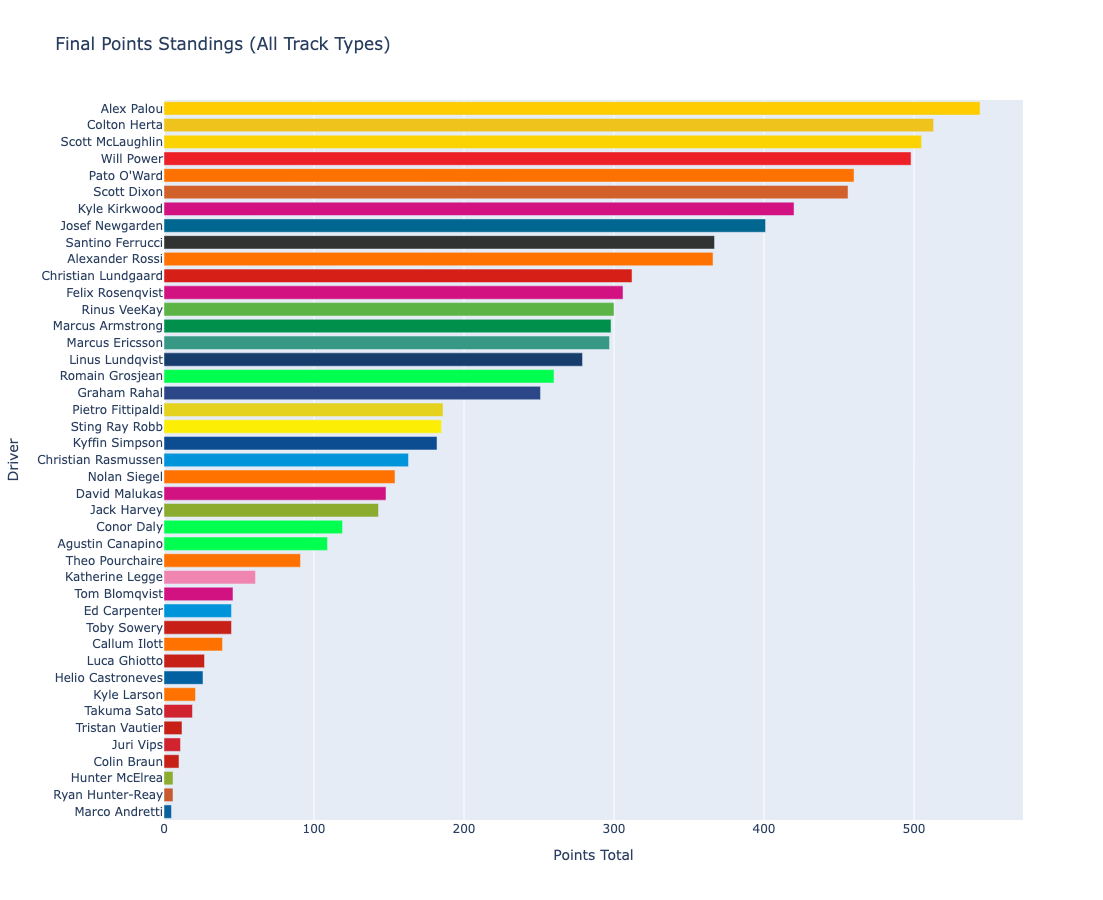

In [404]:
race_result_df_sorted_all_tracks = race_result_df_sorted
race_result_df_sorted_all_tracks['Points Total'] = race_result_df_sorted_all_tracks.groupby('Driver')['Points'].cumsum()
race_result_df_sorted_all_tracks['Championship Rank'] = race_result_df_sorted_all_tracks.groupby('Race')['Points Total'].rank(method='min', ascending=False).astype('int')

total_points_all_tracks = race_result_df_sorted_all_tracks.groupby('Driver')['Points Total'].max().reset_index().sort_values(by='Points Total', ascending=False)
total_points_all_tracks['Championship Rank'] = total_points_all_tracks['Points Total'].rank(method='min', ascending=False).astype('int')
total_points_all_tracks['Championship Result'] = total_points_all_tracks['Championship Rank']
total_points_all_tracks.set_index('Championship Rank', inplace=True)
championship_rank_all_tracks = total_points_all_tracks['Driver'].tolist()

graph_official_points = px.line(race_result_df_sorted_all_tracks, x='Race', y='Points Total', color='Driver', 
              title='Points (All Track Types)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_all_tracks}, hover_data=['Championship Rank', 'Race Number'])

graph_official_champ_rank = px.line(race_result_df_sorted_all_tracks, x='Race', y='Championship Rank', color='Driver', 
              title='Championship Rank (All Track Types)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_all_tracks}, hover_data=['Championship Rank', 'Race Number'])
graph_official_champ_rank.update_yaxes(autorange='reversed')

bar_official_points = px.bar(total_points_all_tracks, y='Driver', x='Points Total', color='Driver',
             title='Final Points Standings (All Track Types)', color_discrete_map=driver_car_colors, height=900, hover_data=['Championship Result'])
bar_official_points.update_layout(showlegend=False)


graph_official_points.show()
graph_official_champ_rank.show()
bar_official_points.show()

/var/folders/t8/l9kd_x7536j_fhxbslcjdcth0000gn/T/ipykernel_2687/1239716790.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t8/l9kd_x7536j_fhxbslcjdcth0000gn/T/ipykernel_2687/1239716790.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



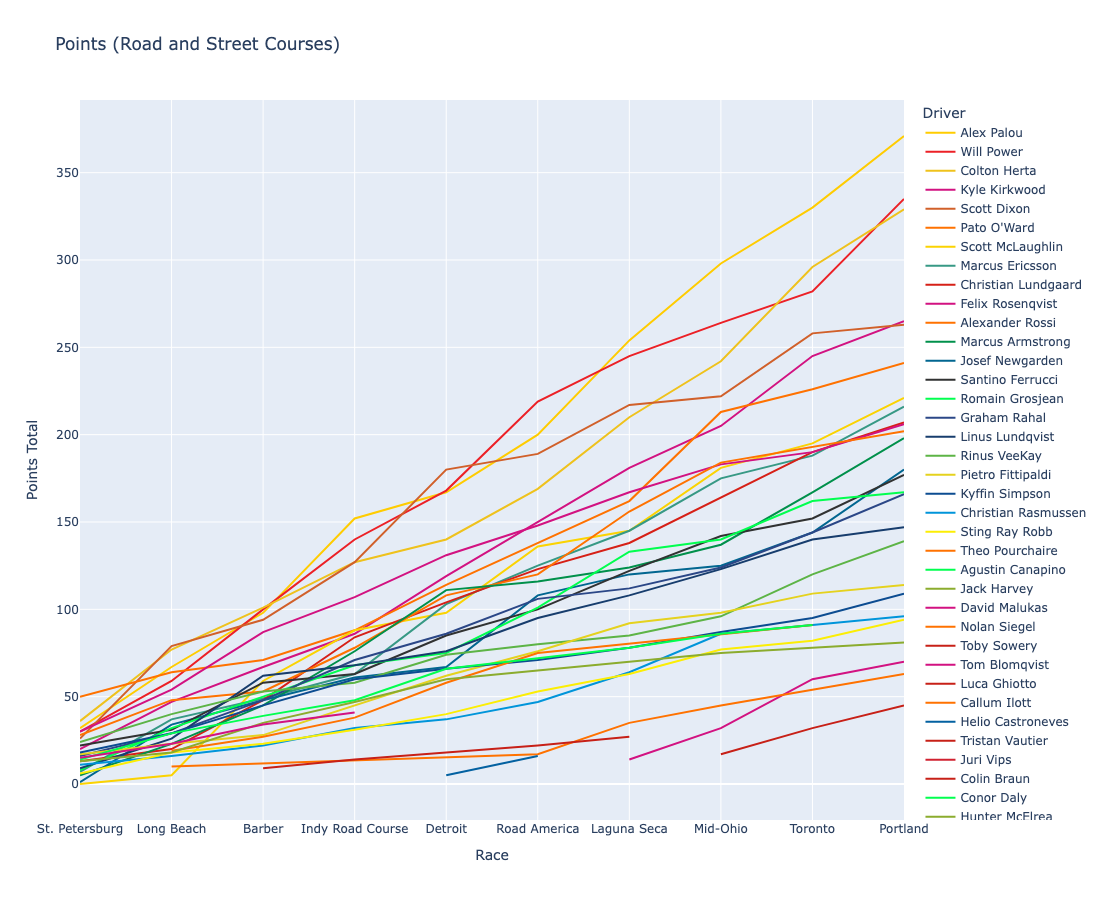

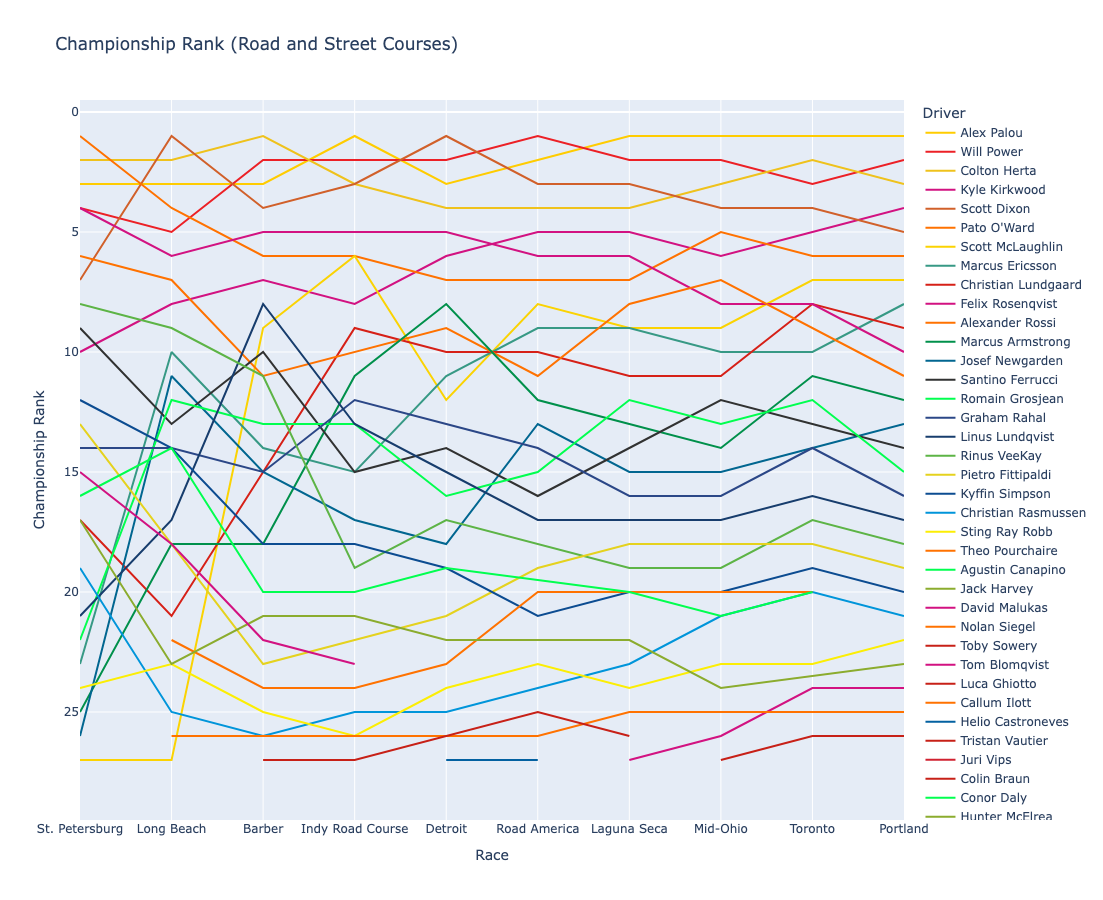

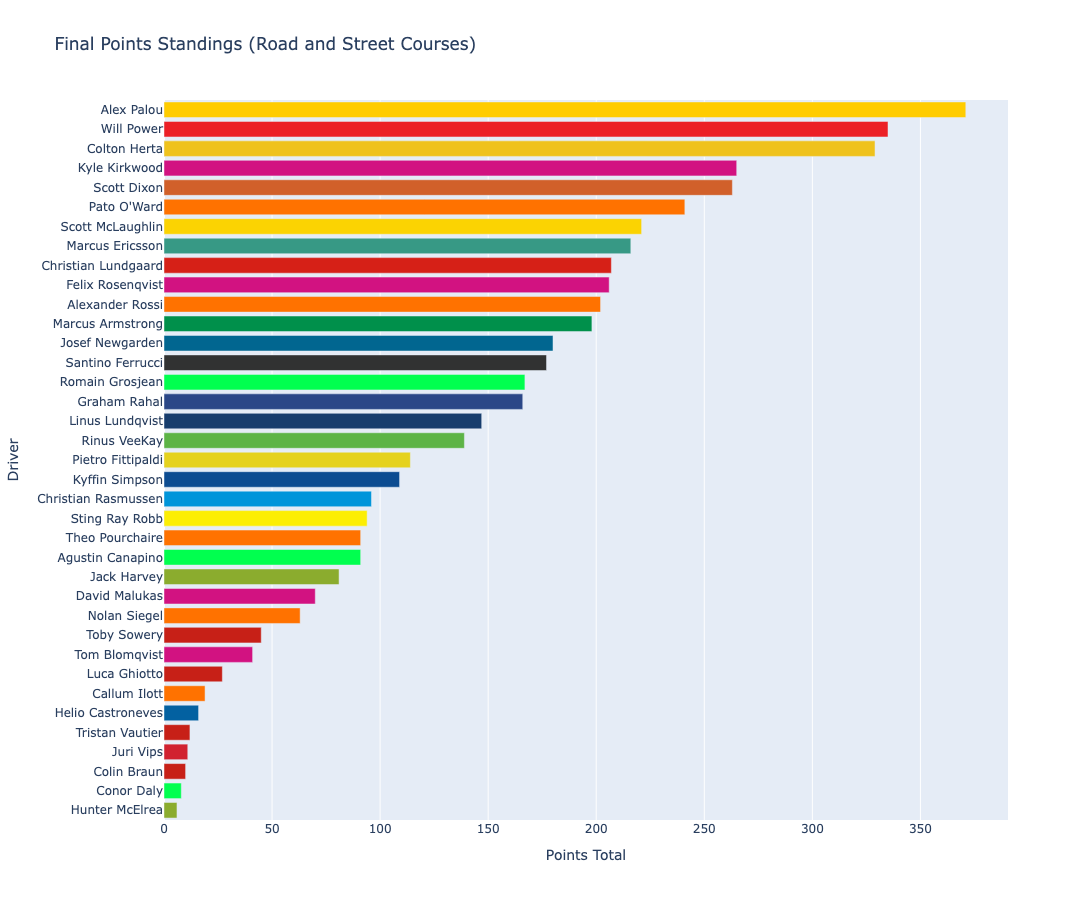

In [405]:
race_result_df_sorted_road_street = race_result_df_sorted[race_result_df_sorted['Track Type'] != 'Oval']
race_result_df_sorted_road_street['Points Total'] = race_result_df_sorted_road_street.groupby('Driver')['Points'].cumsum()
race_result_df_sorted_road_street['Championship Rank'] = race_result_df_sorted_road_street.groupby('Race')['Points Total'].rank(method='min', ascending=False).astype('int')

total_points_road_street = race_result_df_sorted_road_street.groupby('Driver')['Points Total'].max().reset_index().sort_values(by='Points Total', ascending=False)
total_points_road_street['Championship Rank'] = total_points_road_street['Points Total'].rank(method='min', ascending=False).astype('int')
total_points_road_street['Championship Result'] = total_points_road_street['Championship Rank']
total_points_road_street.set_index('Championship Rank', inplace=True)
championship_rank_road_street = total_points_road_street['Driver'].tolist()

graph_official_points_road_street = px.line(race_result_df_sorted_road_street, x='Race', y='Points Total', color='Driver', 
              title='Points (Road and Street Courses)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_road_street}, hover_data=['Championship Rank'])

graph_official_champ_rank_road_street = px.line(race_result_df_sorted_road_street, x='Race', y='Championship Rank', color='Driver', 
              title='Championship Rank (Road and Street Courses)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_road_street}, hover_data=['Championship Rank'])
graph_official_champ_rank_road_street.update_yaxes(autorange='reversed')

bar_official_points_road_street = px.bar(total_points_road_street, y='Driver', x='Points Total', color='Driver',
             title='Final Points Standings (Road and Street Courses)', color_discrete_map=driver_car_colors, height=900, hover_data=['Championship Result'])
bar_official_points_road_street.update_layout(showlegend=False)


graph_official_points_road_street.show()
graph_official_champ_rank_road_street.show()
bar_official_points_road_street.show()

/var/folders/t8/l9kd_x7536j_fhxbslcjdcth0000gn/T/ipykernel_2687/3894256563.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t8/l9kd_x7536j_fhxbslcjdcth0000gn/T/ipykernel_2687/3894256563.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



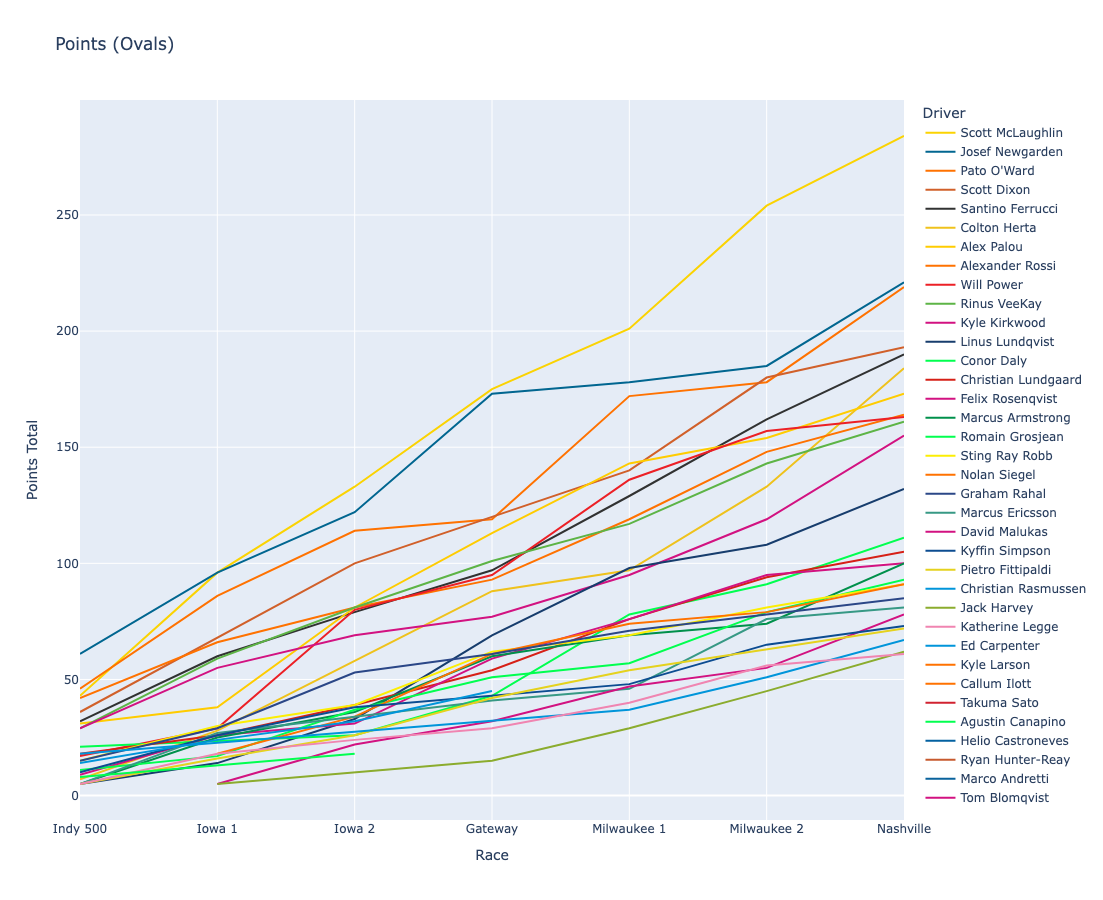

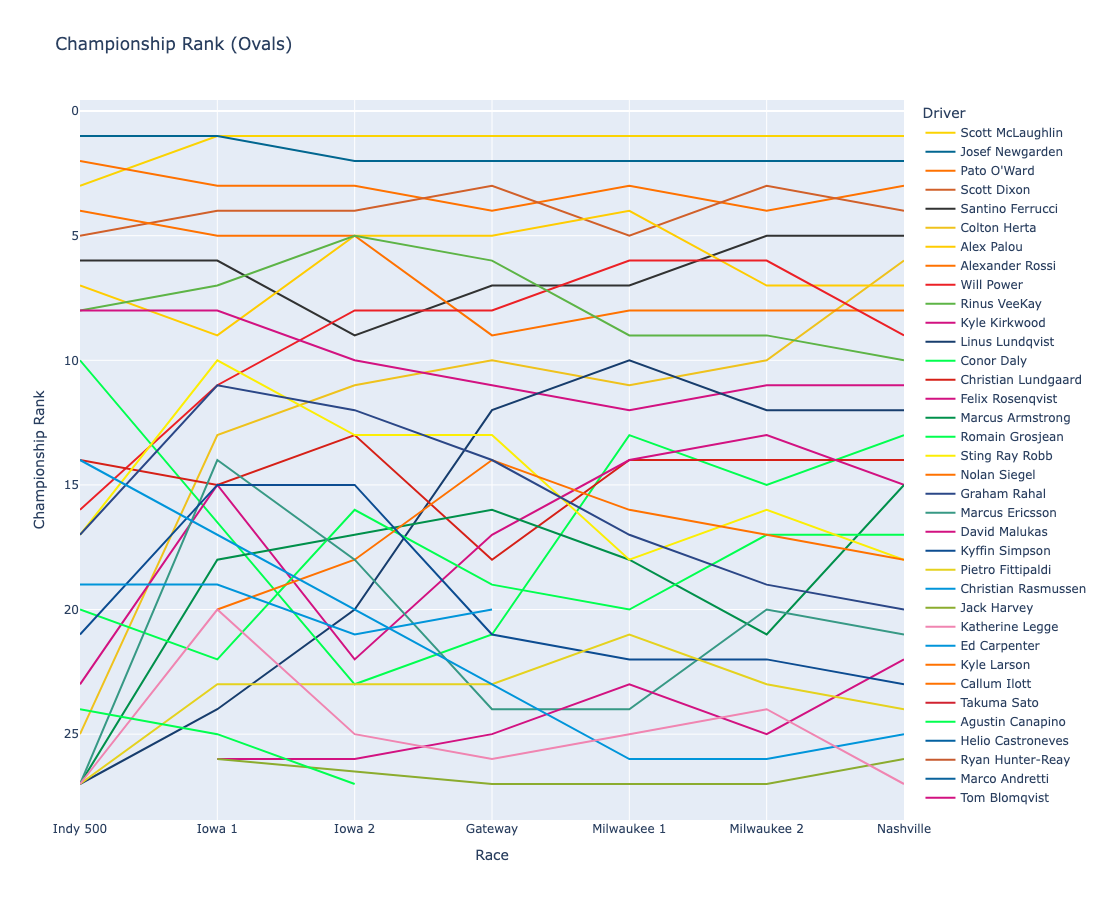

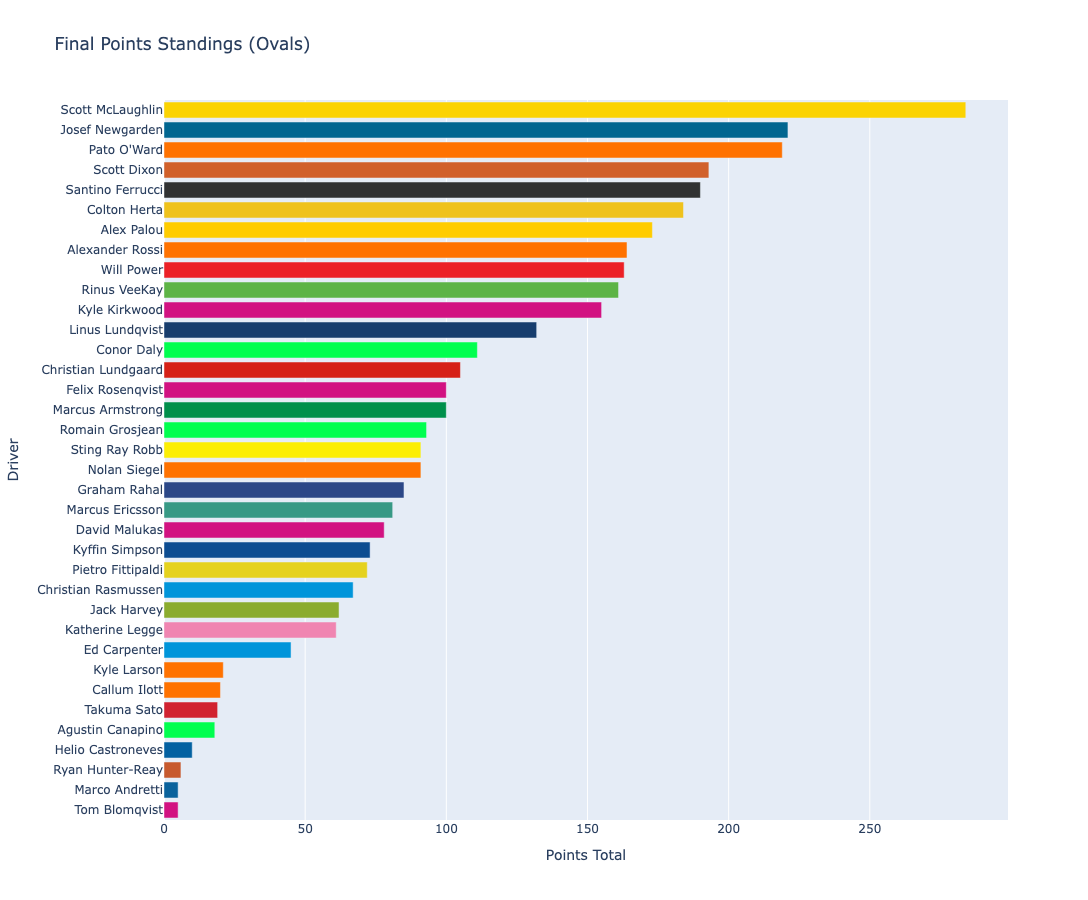

In [406]:
race_result_df_sorted_oval = race_result_df_sorted[race_result_df_sorted['Track Type'] == 'Oval']
race_result_df_sorted_oval['Points Total'] = race_result_df_sorted_oval.groupby('Driver')['Points'].cumsum()
race_result_df_sorted_oval['Championship Rank'] = race_result_df_sorted_oval.groupby('Race')['Points Total'].rank(method='min', ascending=False).astype('int')

total_points_oval = race_result_df_sorted_oval.groupby('Driver')['Points Total'].max().reset_index().sort_values(by='Points Total', ascending=False)
total_points_oval['Championship Rank'] = total_points_oval['Points Total'].rank(method='min', ascending=False).astype('int')
total_points_oval['Championship Result'] = total_points_oval['Championship Rank']
total_points_oval.set_index('Championship Rank', inplace=True)
championship_rank_oval = total_points_oval['Driver'].tolist()

graph_official_points_oval = px.line(race_result_df_sorted_oval, x='Race', y='Points Total', color='Driver', 
              title='Points (Ovals)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_oval}, hover_data=['Championship Rank'])

graph_official_champ_rank_oval = px.line(race_result_df_sorted_oval, x='Race', y='Championship Rank', color='Driver', 
              title='Championship Rank (Ovals)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_oval}, hover_data=['Championship Rank'])
graph_official_champ_rank_oval.update_yaxes(autorange='reversed')

bar_official_points_oval = px.bar(total_points_oval, y='Driver', x='Points Total', color='Driver',
             title='Final Points Standings (Ovals)', color_discrete_map=driver_car_colors, height=900, hover_data=['Championship Result'])
bar_official_points_oval.update_layout(showlegend=False)


graph_official_points_oval.show()
graph_official_champ_rank_oval.show()
bar_official_points_oval.show()

In [407]:
driver_specialities = pd.merge(total_points_oval, total_points_road_street, on='Driver', how='outer')
driver_specialities = pd.merge(driver_specialities, total_points_all_tracks, on='Driver', how='inner')
driver_specialities = driver_specialities.rename(columns={'Championship Result_x': 'Road and Street Course Rank', 'Championship Result_y': 'Oval Rank'}).drop(columns=['Points Total_x', 'Points Total_y', 'Points Total'])
driver_specialities['Road and Street Course Rank'] = driver_specialities['Road and Street Course Rank'].fillna(50).astype('int')
driver_specialities['Oval Rank'] = driver_specialities['Oval Rank'].fillna(50).astype('int')
driver_specialities.sort_values(by='Championship Result', inplace=True)
driver_specialities.set_index('Championship Result', inplace=True)

track_pref_logic = [
    driver_specialities['Road and Street Course Rank'] > driver_specialities['Oval Rank'],  # Condition for road/street course specialist
    driver_specialities['Road and Street Course Rank'] < driver_specialities['Oval Rank'],  # Condition for oval specialist
    driver_specialities['Road and Street Course Rank'] == driver_specialities['Oval Rank']   # Condition for no preference
]
track_pref = [
    'Road and Street Courses',
    'Ovals',
    'No Preference'
]
driver_specialities['Track Preference'] = np.select(track_pref_logic, track_pref)
driver_specialities

Driver  Road and Street Course Rank  \
Championship Result                                                     
1                             Alex Palou                            7   
2                           Colton Herta                            6   
3                       Scott McLaughlin                            1   
4                             Will Power                            9   
5                            Pato O'Ward                            3   
6                            Scott Dixon                            4   
7                          Kyle Kirkwood                           11   
8                        Josef Newgarden                            2   
9                       Santino Ferrucci                            5   
10                       Alexander Rossi                            8   
11                   Christian Lundgaard                           14   
12                      Felix Rosenqvist                           15   
13                          Rinus VeeKay                           10   
14                      Marcus Armstrong                           15   
15                       Marcus Ericsson                           21   
16                       Linus Lundqvist                           12   
17                       Romain Grosjean                           17   
18                          Graham Rahal                           20   
19                     Pietro Fittipaldi                           24   
20                        Sting Ray Robb                           18   
21                        Kyffin Simpson                           23   
22                   Christian Rasmussen                           25   
23                          Nolan Siegel                           18   
24                         David Malukas                           22   
25                           Jack Harvey                           26   
26                            Conor Daly                           13   
27                      Agustin Canapino                           32   
28                       Theo Pourchaire                           50   
29                       Katherine Legge                           27   
30                         Tom Blomqvist                           35   
31                          Ed Carpenter                           28   
31                           Toby Sowery                           50   
33                          Callum Ilott                           30   
34                          Luca Ghiotto                           50   
35                     Helio Castroneves                           33   
36                           Kyle Larson                           29   
37                           Takuma Sato                           31   
38                       Tristan Vautier                           50   
39                             Juri Vips                           50   
40                           Colin Braun                           50   
41                        Hunter McElrea                           50   
41                      Ryan Hunter-Reay                           34   
43                        Marco Andretti                           35   

                     Oval Rank         Track Preference  
Championship Result                                      
1                            1  Road and Street Courses  
2                            3  Road and Street Courses  
3                            7                    Ovals  
4                            2  Road and Street Courses  
5                            6                    Ovals  
6                            5                    Ovals  
7                            4  Road and Street Courses  
8                           13                    Ovals  
9                           14                    Ovals  
10                          11                    Ovals  
11                           9  Road and Street Cour

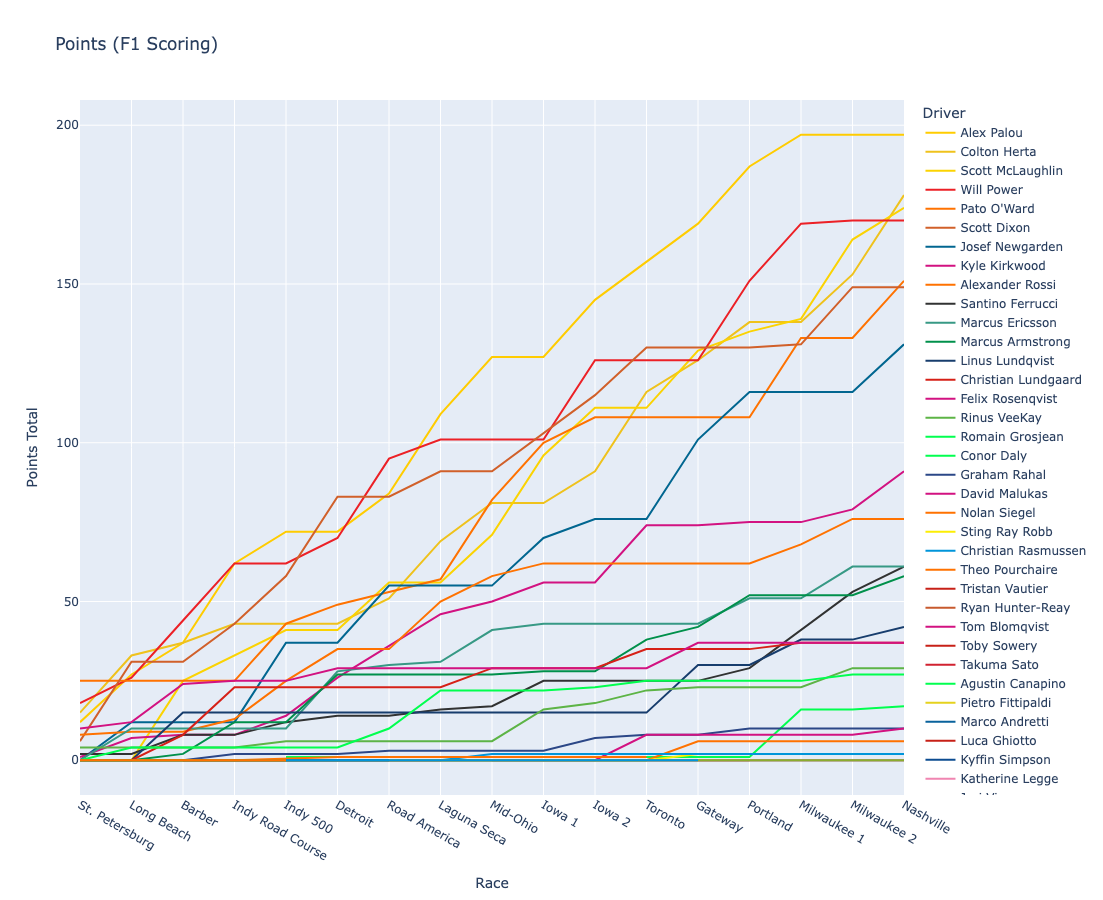

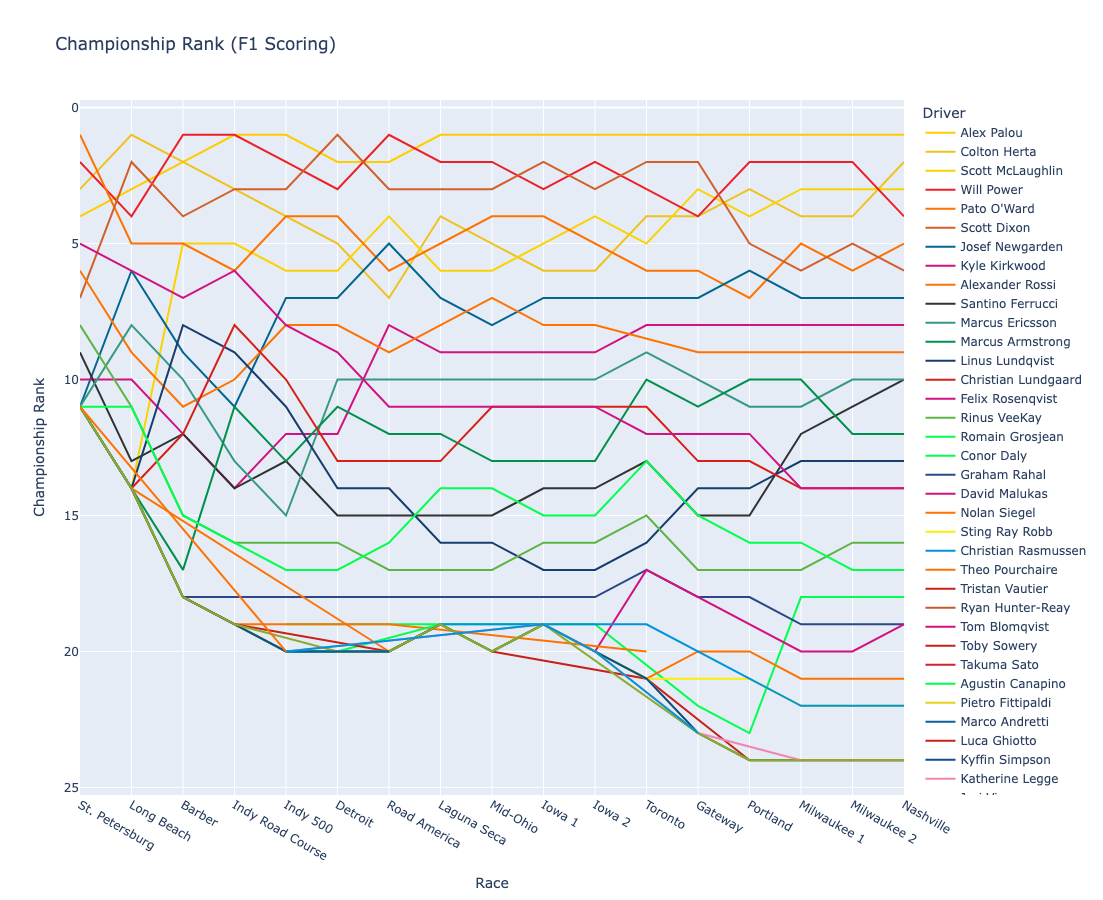

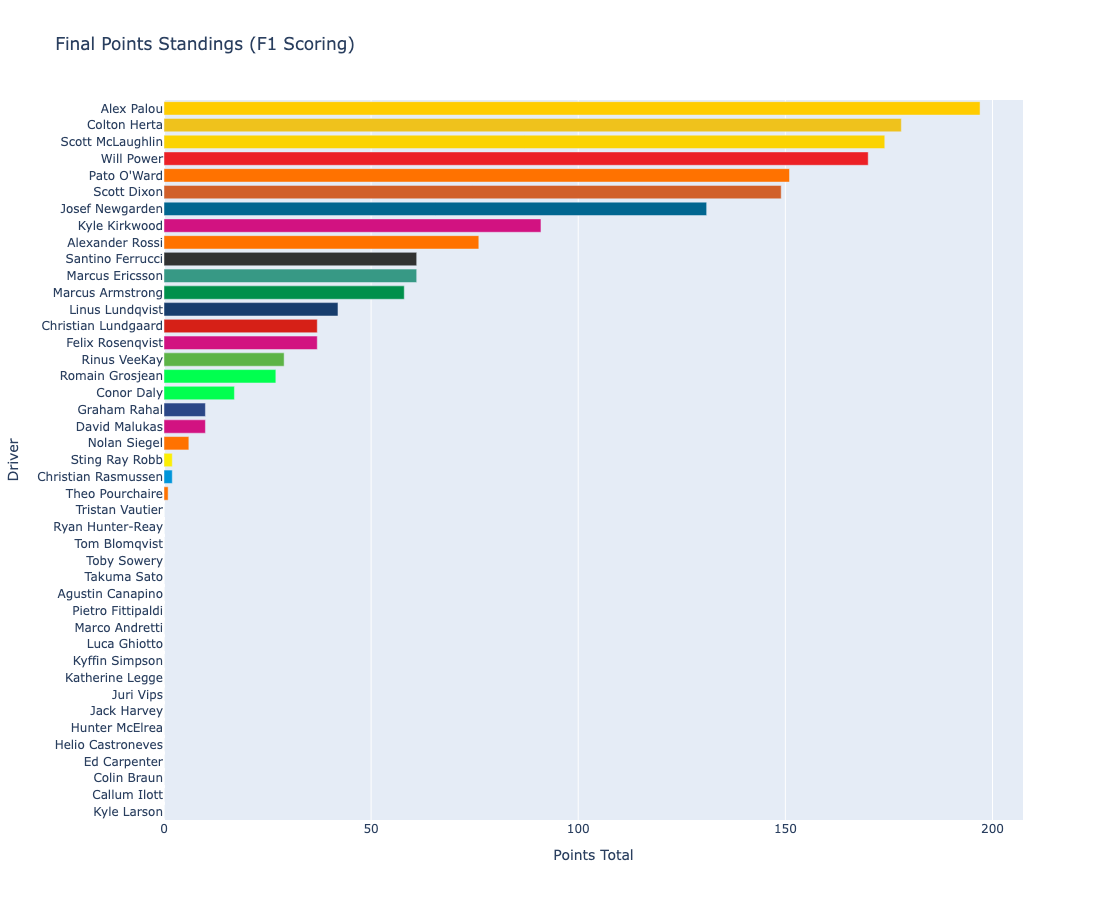

In [411]:
race_result_df_sorted_f1_points = race_result_df_sorted
race_result_df_sorted_f1_points['Points Total'] = race_result_df_sorted_f1_points.groupby('Driver')['Points (F1 Scoring)'].cumsum()
race_result_df_sorted_f1_points['Championship Rank'] = race_result_df_sorted_f1_points.groupby('Race')['Points Total'].rank(method='min', ascending=False).astype('int')

total_points_f1_points = race_result_df_sorted_f1_points.groupby('Driver')['Points Total'].max().reset_index().sort_values(by='Points Total', ascending=False)
total_points_f1_points['Championship Rank'] = total_points_f1_points['Points Total'].rank(method='min', ascending=False).astype('int')
total_points_f1_points['Championship Result'] = total_points_f1_points['Championship Rank']
total_points_f1_points.set_index('Championship Rank', inplace=True)
championship_rank_f1_points = total_points_f1_points['Driver'].tolist()

graph_f1_points = px.line(race_result_df_sorted_f1_points, x='Race', y='Points Total', color='Driver', 
              title='Points (F1 Scoring)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_f1_points}, hover_data=['Championship Rank', 'Race Number'])

graph_championship_f1_points = px.line(race_result_df_sorted_f1_points, x='Race', y='Championship Rank', color='Driver', 
              title='Championship Rank (F1 Scoring)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_f1_points}, hover_data=['Championship Rank', 'Race Number'])
graph_championship_f1_points.update_yaxes(autorange='reversed')

bar_f1_points = px.bar(total_points_f1_points, y='Driver', x='Points Total', color='Driver',
             title='Final Points Standings (F1 Scoring)', color_discrete_map=driver_car_colors, height=900, hover_data=['Championship Result'])
bar_f1_points.update_layout(showlegend=False)


graph_f1_points.show()
graph_championship_f1_points.show()
bar_f1_points.show()

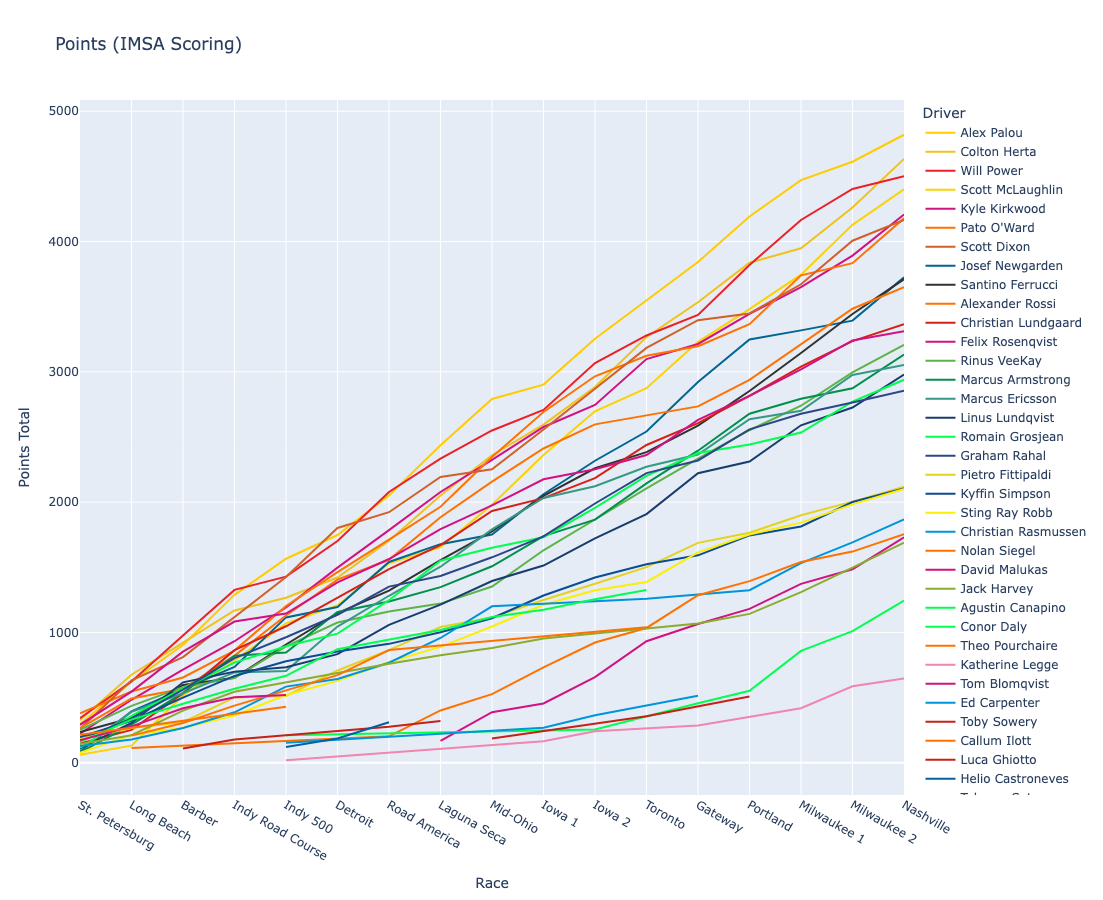

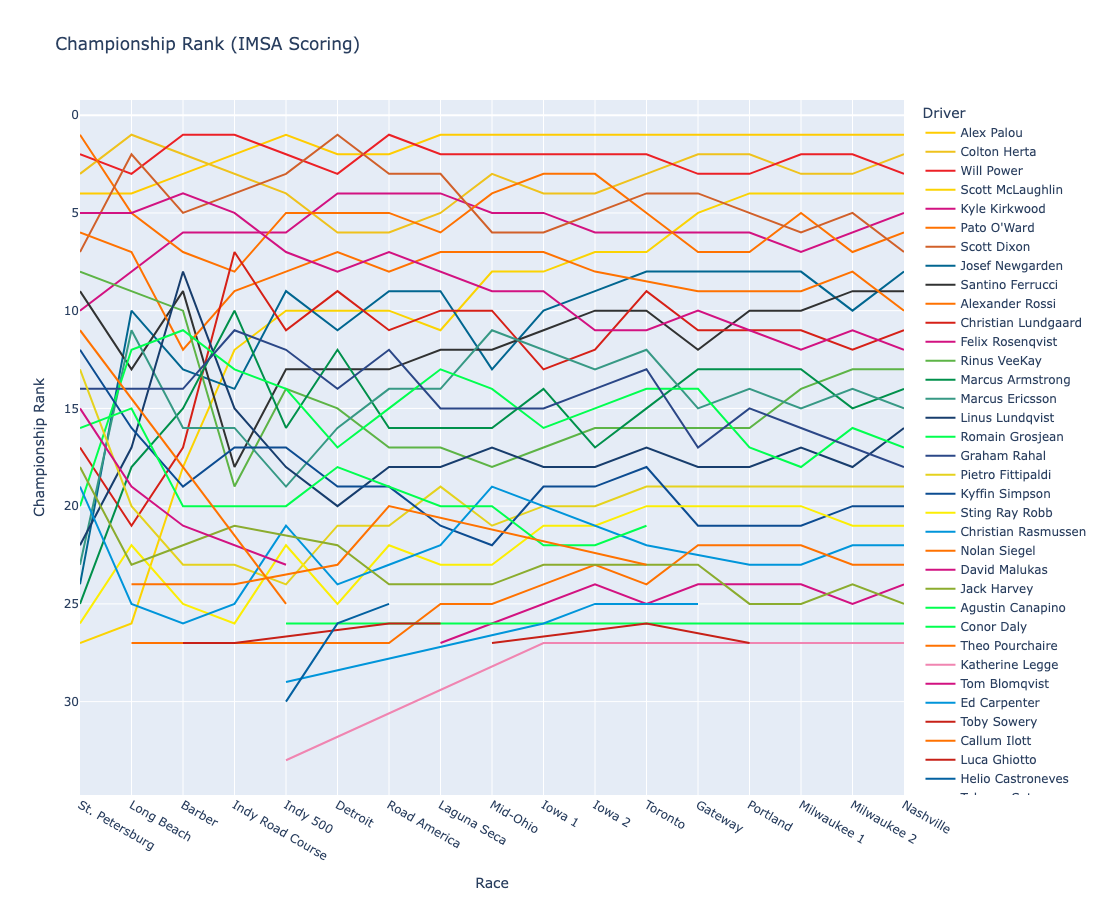

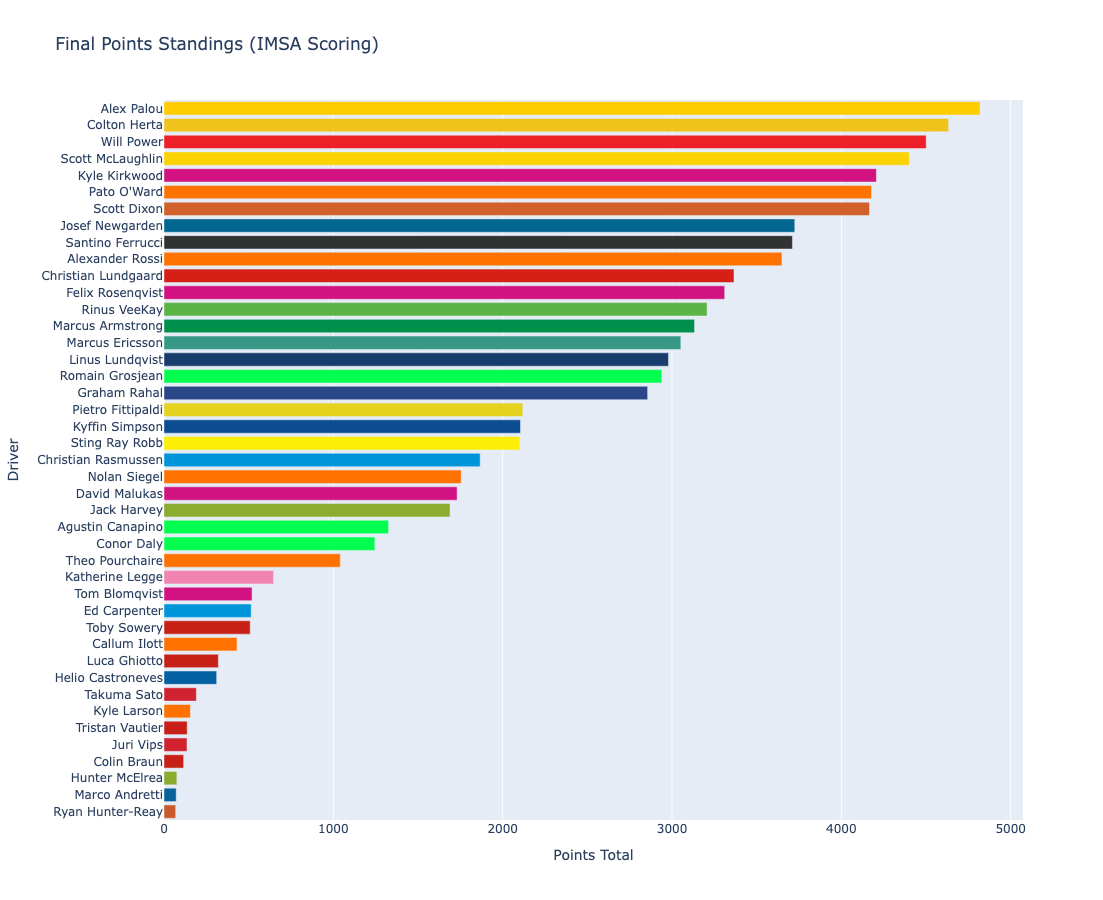

In [412]:
race_result_df_sorted_imsa_points = race_result_df_sorted
race_result_df_sorted_imsa_points['Points Total'] = race_result_df_sorted_imsa_points.groupby('Driver')['Points (IMSA Scoring)'].cumsum()
race_result_df_sorted_imsa_points['Championship Rank'] = race_result_df_sorted_imsa_points.groupby('Race')['Points Total'].rank(method='min', ascending=False).astype('int')

total_points_imsa_points = race_result_df_sorted_imsa_points.groupby('Driver')['Points Total'].max().reset_index().sort_values(by='Points Total', ascending=False)
total_points_imsa_points['Championship Rank'] = total_points_imsa_points['Points Total'].rank(method='min', ascending=False).astype('int')
total_points_imsa_points['Championship Result'] = total_points_imsa_points['Championship Rank']
total_points_imsa_points.set_index('Championship Rank', inplace=True)
championship_rank_imsa_points = total_points_imsa_points['Driver'].tolist()

graph_imsa_points = px.line(race_result_df_sorted_imsa_points, x='Race', y='Points Total', color='Driver', 
              title='Points (IMSA Scoring)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_imsa_points}, hover_data=['Championship Rank', 'Race Number'])

graph_championship_imsa_points = px.line(race_result_df_sorted_imsa_points, x='Race', y='Championship Rank', color='Driver', 
              title='Championship Rank (IMSA Scoring)', height=900, color_discrete_map=driver_car_colors, category_orders={'Driver': championship_rank_imsa_points}, hover_data=['Championship Rank', 'Race Number'])
graph_championship_imsa_points.update_yaxes(autorange='reversed')

bar_imsa_points = px.bar(total_points_imsa_points, y='Driver', x='Points Total', color='Driver',
             title='Final Points Standings (IMSA Scoring)', color_discrete_map=driver_car_colors, height=900, hover_data=['Championship Result'])
bar_imsa_points.update_layout(showlegend=False)


graph_imsa_points.show()
graph_championship_imsa_points.show()
bar_imsa_points.show()